UEP run 18 results. Using $\mu = 10^4$. This run is the first run to optimize the upper bound of the Western north american functional.

For starting positions, we made the following choices
1. $w$: use the negative stop of LEP 08
2. $c$: to indicate that none of the constraints is active at start, we initialize this point to 0s.
3. $\lambda$: we start at a vector of 1s. This notebook both analyzes the results and generates the starting positions.

Other components
1. Optimization sub-results
2. Generate starting positions

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pickle
from scipy import stats

In [2]:
from generate_opt_objects import A_b_generation

**PNC:/Users/mikestanley/anaconda3/envs/mc_sampling/lib/python3.8/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  pyproj could not be found, so IO/API coordinates cannot be converted to lat/lon; to fix, install pyproj or basemap (e.g., `pip install pyproj)`


In [3]:
# results base directory
BASE_DIR = './data/carbon_flux/results'

# save filepath
SAVE_FIG_BASE = '../figures/interval_optimizations/continental_US_jun2010/dual/18'

In [4]:
# paths
OBS_FP = '../fixed_optimization_inputs/y_affine_corrected.npy'

In [5]:
# get necessary objects
with open(OBS_FP, 'rb') as f:
    y_obs = np.load(f)
    
# gosat data
with open('../fixed_optimization_inputs/gosat_df_jan1_aug31_2010.csv', 'rb') as f:
    gosat_df = pd.read_csv(f)
L_inv_vec = 1 / gosat_df.xco2_unc.values
    
# tranform the data
y_tilde = np.multiply(L_inv_vec, y_obs)

CONSTR_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization/data/sign_corrected'
A, b = A_b_generation(
    box_constraint_fp=CONSTR_DIR + '/scipy_bnds.pkl'
)

FUNC_FP = '/Users/mikestanley/Research/Carbon_Flux/optimization'
FUNC_FP += '/src_admm/data/carbon_flux/objects/wna_june_functional.npy'
with open(FUNC_FP, 'rb') as f:
    h = np.load(f)

In [6]:
# psi_alpha
with open('./data/carbon_flux/objects/opt_res_cont.pkl', 'rb') as f:
    opt_slack = pickle.load(f)
    
PSI_ALPHA = np.sqrt(stats.chi2.ppf(q=.95, df=1) + opt_slack[1])

#### Compute the true functional value

In [7]:
# read in the functional (no control flux)
with open('./data/carbon_flux/objects/wna_june_functiona_no_control_flux.npy', 'rb') as f:
    h = np.load(f)
    
# read in the full NA functional for comparison
with open('../data/na_june_functional_no_control.npy', 'rb') as f:
    h_na = np.load(f)
    
# read in the true fluxes
with open('../data/jules_month_avg.npy', 'rb') as f:
    true_fluxes = np.load(f)[:8, :, :]
    
# swap the axes for correct computation
true_fluxes = np.swapaxes(true_fluxes, axis1=1, axis2=2)
    
func_na = np.dot(h_na, true_fluxes.flatten())
func_wna = np.dot(h, true_fluxes.flatten())

print(f'NA Functional     : {func_na}')
print(f'West-NA Functional: {func_wna}')

NA Functional     : -0.43602474289495025
West-NA Functional: -0.612904970831845


# Plotting functions

In [8]:
def global_avg_plot(w_ser, title_str=None, figsize=(8, 5)):
    """
    Globally averaged weights at daily, weekly, and month res
    
    Parameters
    ----------
        w_ser (pandas series) : weights indexed by time
    """
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ts_day = w_ser.resample('D').mean()
    ts_week = w_ser.resample('W').mean()
    ts_month = w_ser.resample('M').mean()
    ts_day.plot(ax=ax, label='Day')
    ts_week.plot(ax=ax, label='Week')
    ts_month.plot(ax=ax, label='Month')
    ax.axhline(0, linestyle='--', color='gray')
    ax.legend()
    ax.set_title(title_str)
    plt.show()
    
def month_map_plot(df, w_col_str, norm, vmin=None, vmax=None, figsize=(12, 16), save_fp=None):
    """
    Monthly heat maps for the given weights
    
    Parameters
    ----------
        df        (pandas dataframe)  : contains columns - 'month', 'lon', 'lat', and w_col_str
        w_col_str (str)               : name of w column in df to use
        norm      (mcolors.Normalize) : for color scheme
    """
    # w start
    fig, ax = plt.subplots(ncols=2, nrows=4, figsize=figsize)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

    for i in range(8):
        row_idx = i // 2
        col_idx = i % 2
        month_idxs = df['month'].astype(int) == i + 1
        sp_i = ax[row_idx, col_idx].scatter(
            df['lon'][month_idxs], df['lat'][month_idxs],
            c=df[w_col_str][month_idxs],
            norm=norm, vmin=vmin, vmax=vmax,
            s=14, cmap='seismic'
        )
        ax[row_idx, col_idx].set_title(months[i])

    plt.colorbar(sp_i,ax=ax[0, 0])
    if save_fp:
        plt.savefig(save_fp, dpi=300)
        plt.close()
    else:
        plt.show()

# Optimization diagnostics

#### Convergence Plots

In [9]:
# read in the raw stdout file
with open(BASE_DIR + '/18/stdout.txt', 'r') as f:
    stdout_raw = f.readlines()

In [12]:
# isolate the trajectories from the w optimization
all_obj_vals = [float(line[22:34].replace('D', 'e')) for line in stdout_raw if 'At iterate' in line]
traj_w_01 = all_obj_vals[:3]
traj_c_01 = all_obj_vals[3:5]
traj_w_02 = all_obj_vals[5:7]
traj_c_02 = all_obj_vals[7:10]
traj_w_03 = all_obj_vals[10:12]
traj_c_03 = all_obj_vals[12:14]
traj_w_04 = all_obj_vals[14:15]
traj_c_04 = all_obj_vals[15:17]
traj_w_05 = all_obj_vals[17:19]
traj_c_05 = all_obj_vals[19:21]
traj_w_06 = all_obj_vals[21:23]
traj_c_06 = all_obj_vals[23:25]
traj_w_07 = all_obj_vals[25:26]
traj_c_07 = all_obj_vals[26:28]
traj_w_08 = all_obj_vals[28:29]
traj_c_08 = all_obj_vals[29:31]
traj_w_09 = all_obj_vals[31:32]
traj_c_09 = all_obj_vals[32:34]
traj_w_10 = all_obj_vals[34:36]
traj_c_10 = all_obj_vals[36:]

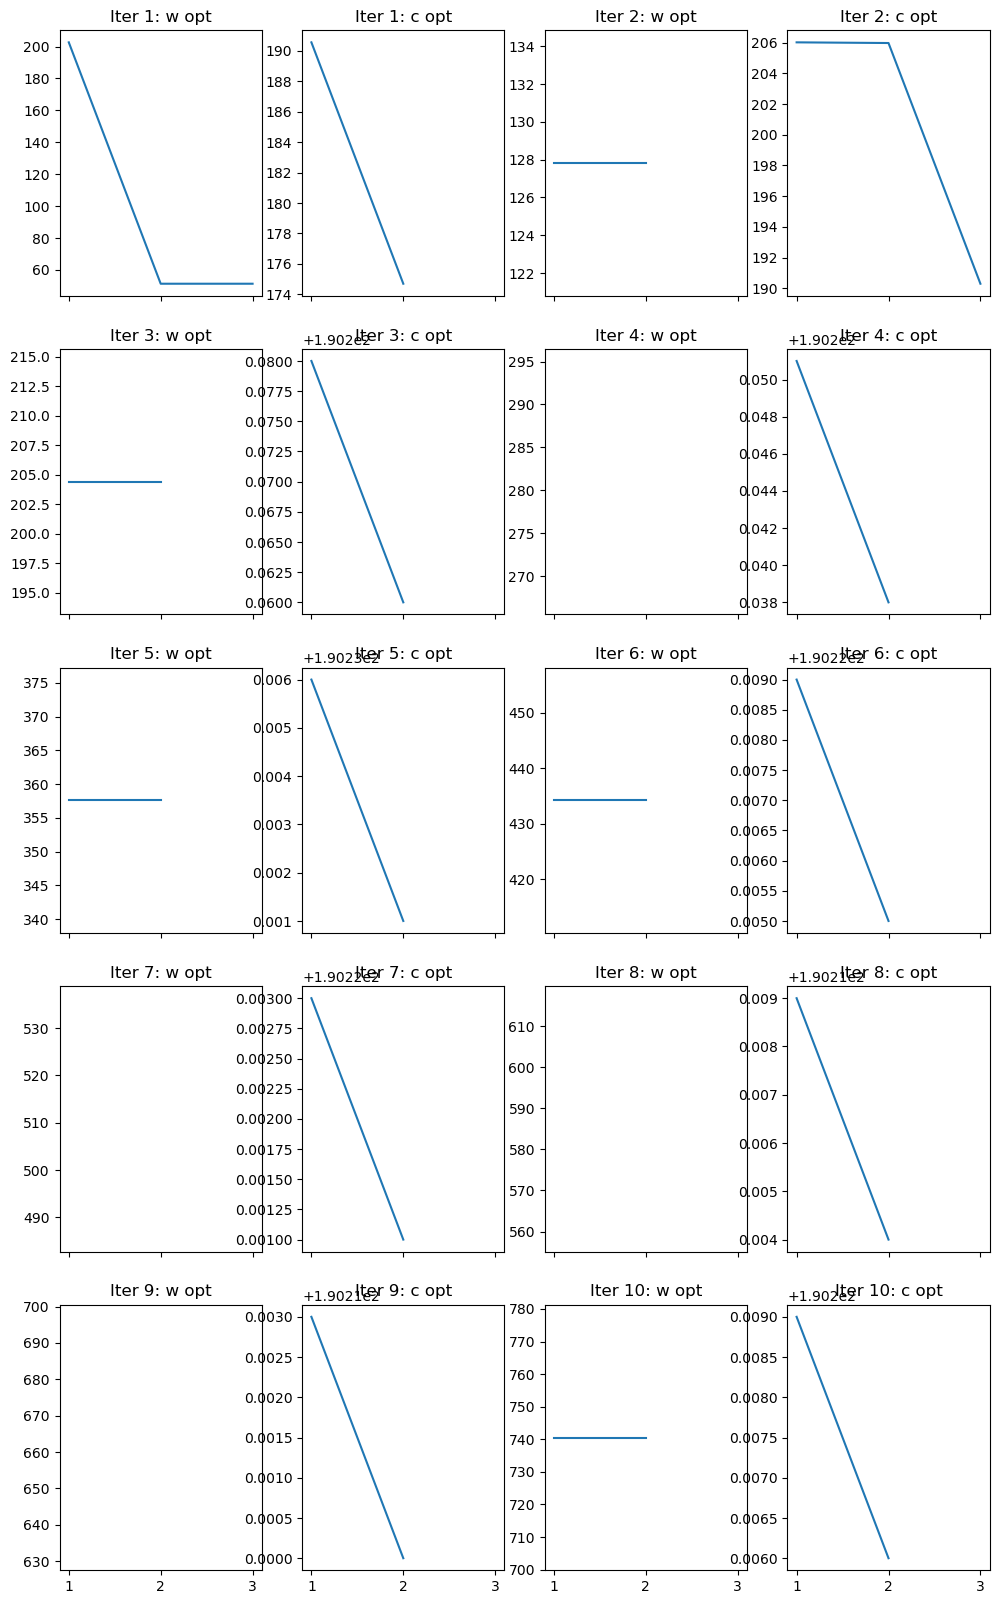

In [13]:
fig, ax = plt.subplots(ncols=4, nrows=5, figsize=(12, 20), sharex=True)

# iteration 1
ax[0, 0].plot(np.arange(1, len(traj_w_01) + 1), traj_w_01)
ax[0, 1].plot(np.arange(1, len(traj_c_01) + 1), traj_c_01)

# iteration 2
ax[0, 2].plot(np.arange(1, len(traj_w_02) + 1), traj_w_02)
ax[0, 3].plot(np.arange(1, len(traj_c_02) + 1), traj_c_02)

# iteration 3
ax[1, 0].plot(np.arange(1, len(traj_w_03) + 1), traj_w_03)
ax[1, 1].plot(np.arange(1, len(traj_c_03) + 1), traj_c_03)

# iteration 4
ax[1, 2].plot(np.arange(1, len(traj_w_04) + 1), traj_w_04)
ax[1, 3].plot(np.arange(1, len(traj_c_04) + 1), traj_c_04)

# iteration 5
ax[2, 0].plot(np.arange(1, len(traj_w_05) + 1), traj_w_05)
ax[2, 1].plot(np.arange(1, len(traj_c_05) + 1), traj_c_05)

# iteration 6
ax[2, 2].plot(np.arange(1, len(traj_w_06) + 1), traj_w_06)
ax[2, 3].plot(np.arange(1, len(traj_c_06) + 1), traj_c_06)

# iteration 7
ax[3, 0].plot(np.arange(1, len(traj_w_07) + 1), traj_w_07)
ax[3, 1].plot(np.arange(1, len(traj_c_07) + 1), traj_c_07)

# iteration 8
ax[3, 2].plot(np.arange(1, len(traj_w_08) + 1), traj_w_08)
ax[3, 3].plot(np.arange(1, len(traj_c_08) + 1), traj_c_08)

# iteration 9
ax[4, 0].plot(np.arange(1, len(traj_w_09) + 1), traj_w_09)
ax[4, 1].plot(np.arange(1, len(traj_c_09) + 1), traj_c_09)

# iteration 10
ax[4, 2].plot(np.arange(1, len(traj_w_10) + 1), traj_w_10)
ax[4, 3].plot(np.arange(1, len(traj_c_10) + 1), traj_c_10)

# labels
ax[0, 0].set_title('Iter 1: w opt')
ax[0, 1].set_title('Iter 1: c opt')
ax[0, 2].set_title('Iter 2: w opt')
ax[0, 3].set_title('Iter 2: c opt')
ax[1, 0].set_title('Iter 3: w opt')
ax[1, 1].set_title('Iter 3: c opt')
ax[1, 2].set_title('Iter 4: w opt')
ax[1, 3].set_title('Iter 4: c opt')
ax[2, 0].set_title('Iter 5: w opt')
ax[2, 1].set_title('Iter 5: c opt')
ax[2, 2].set_title('Iter 6: w opt')
ax[2, 3].set_title('Iter 6: c opt')
ax[3, 0].set_title('Iter 7: w opt')
ax[3, 1].set_title('Iter 7: c opt')
ax[3, 2].set_title('Iter 8: w opt')
ax[3, 3].set_title('Iter 8: c opt')
ax[4, 0].set_title('Iter 9: w opt')
ax[4, 1].set_title('Iter 9: c opt')
ax[4, 2].set_title('Iter 10: w opt')
ax[4, 3].set_title('Iter 10: c opt')

plt.show()

#### Final Results

In [14]:
# final results from the previous run
with open(BASE_DIR + '/18/final_results.pkl', 'rb') as f:
    final_res = pickle.load(f)
print(final_res)

{'objective_evals': [-31.133320628654673, 0.3405772801712819, 0.4735252592369142, 0.5853279254757877, 0.645034254631595, 0.7085097494851336, 0.7602915916670958, 0.8507523307195101, 0.9219704264205308, 0.9901578567808159], 'w_opt_output': {'vectors': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.77840696e-05, -8.66774285e-05, -3.34485248e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.77840696e-05, -8.66774285e-05, -3.34485248e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.77840696e-05, -8.66774286e-05, -3.34485248e-03],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.77840696e-05, -8.66774286e-05, -3.34485248e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.77840696e-05, -8.66774286e-05, -3.34485248e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.77840696e-05, -8.66774286e-05, -3.34485248e

In [17]:
NUM_ITERS = 10
feasibility = np.zeros(NUM_ITERS)
for i in range(NUM_ITERS):
    feasibility[i] = np.linalg.norm(h - A.T @ final_res['c_opt_output']['vectors'][i] - final_res['KTw_vecs'][i])
print(feasibility)

[0.20346475 0.19557559 0.19556051 0.19555298 0.19554956 0.19554659
 0.19554438 0.19554126 0.19553905 0.19553713]


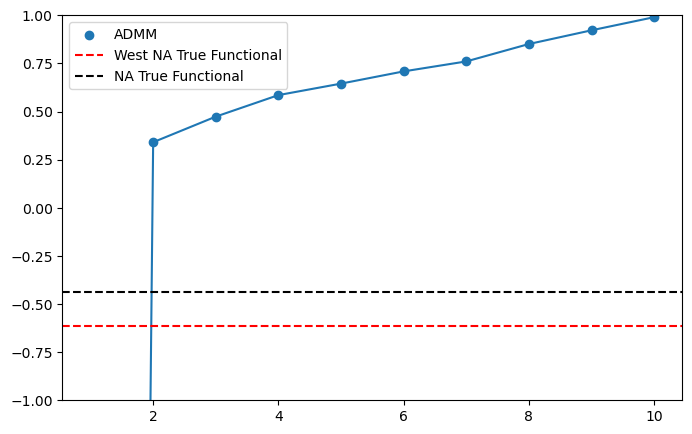

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, NUM_ITERS + 1), final_res['objective_evals'])
plt.scatter(np.arange(1, NUM_ITERS + 1), final_res['objective_evals'], label='ADMM')
plt.axhline(func_wna, linestyle='--', label='West NA True Functional', color='red')
plt.axhline(func_na, linestyle='--', label='NA True Functional', color='black')
plt.ylim(-1, 1)
plt.legend()
plt.show()

# Starting positions

In [8]:
# read in the ending points from LEP08
with open(BASE_DIR + '/08/final_results.pkl', 'rb') as f:
    final_res_08 = pickle.load(f)
    
# get w
w_lep08 = final_res_08['w_opt_output']['vectors'][-1].copy()

In [10]:
# save the new points
SAVE_BASE_SP = './data/carbon_flux/results/18/intermediate_starts'
with open(SAVE_BASE_SP + '/w_start_fromLEP.npy', 'wb') as f:
    np.save(file=f, arr=-w_lep08)  # note the negative
    
# saving c starting position
with open(SAVE_BASE_SP + '/c_start_active0.npy', 'wb') as f:
    np.save(file=f, arr=np.zeros(b.shape[0]))
    
# saving lambda starting position
with open(SAVE_BASE_SP + '/lambda_start_unity.npy', 'wb') as f:
    np.save(file=f, arr=np.ones(A.shape[1]))